# CIFAR

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Why we use CIFAR dataset 

1. CIFAR : very small images and low number of images. 
2. Quick turnaround if we are working on CIFAR rather than imagenette

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *
import matplotlib.pyplot as plt
from fastai2.callback import *


from dlnotebooks.models.simplecnn import *
from dlnotebooks.models.resnet import *


In [ ]:
def accuracy1(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred.int() == targ).float().mean()

# Gathering the data

We will download the data from fastai repository. It's a convenient method to collect the samples

In [ ]:
Resiz

In [ ]:
source = untar_data(URLs.CIFAR)
images = get_image_files(source)
fn = images[0];fn

Path('C:/Users/t158185/.fastai/data/cifar10/test/airplane/1001_airplane.png')

# Create data source

Data source consists of adding transformation for items and assign it to either X or Y. In our case, we will define two transformations

1. Load the image and call it X
2. Load the path , extract label and call it Y

In [ ]:
labeller = RegexLabeller(pat = r'.*?[\\/](\w+)[\\/]\d+_\w+.png$') # parent_label
labeller(fn)

'airplane'

In [ ]:
class ImageResizer(Transform):
    order =0
    "Resize the image using resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): self.size=(size, size)
        self.size, self.resample = size, resample
        
    def encodes(self, o:PILImage): return o.resize(size=self.size, resample = self.resample)
    def encodes(self, o:PILMask): return o.resize(size=self.size, resample=Image.NEAREST)
    

In [ ]:
tfms =[[PILImage.create ], [labeller, Categorize() ]]
dsrc = DataSource(images, tfms)

In [ ]:
dsrc.categorize.vocab

(#10) ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
#hide
t = dsrc[0]
type(t[0]), type(t[1])

(fastai2.vision.core.PILImage, fastai2.torch_core.TensorCategory)

In [ ]:
x, y = dsrc.decode(t)

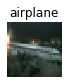

In [ ]:
dsrc.show(t)

# Data Loader

After we are satisfied with the data, we can load the data in memory using batch.

In [ ]:
tdl = TfmdDL(dsrc, bs=16, after_item=[ImageResizer((32,32)), ToTensor(), IntToFloatTensor()])

t = tdl.one_batch()
x, y = tdl.decode_batch(t)[0]
x.shape, y

(torch.Size([3, 32, 32]), 'airplane')

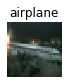

In [ ]:
dsrc.show((x, y))

In [ ]:
split_idx = RandomSplitter()(images)
tfms =[[PILImage.create ], [labeller, Categorize() ]]
dsrc = DataSource(images, tfms, splits=split_idx)

dbunch = dsrc.databunch(bs=16, after_item=[ImageResizer((32,32)), ToTensor(), IntToFloatTensor()], num_workers=0)

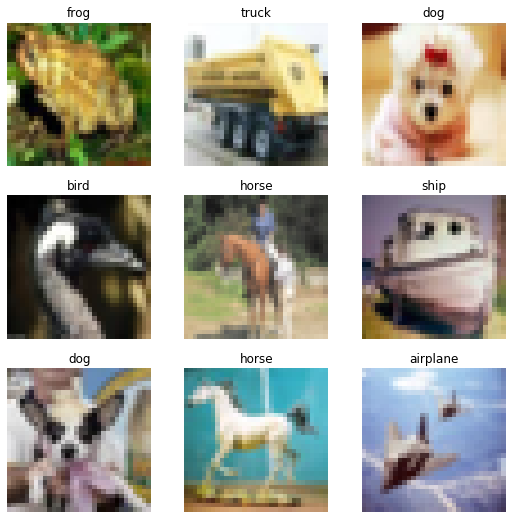

In [ ]:
dbunch.show_batch()

# Simple Linear Connected

Write model for simple linear connected

# Simple CNN without BN

In [ ]:
model = SimpleCNN(); model

SimpleCNN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_out): Conv2d(60, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp], cbs=[ActivationStats(with_hist=True)] ).to_fp16()

In [ ]:
learn.summary()

SimpleCNN (Input shape: ['16 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 10 x 34 x 34    760        True      
________________________________________________________________
Conv2d               16 x 20 x 34 x 34    1,820      True      
________________________________________________________________
MaxPool2d            16 x 20 x 17 x 17    0          False     
________________________________________________________________
Conv2d               16 x 40 x 17 x 17    7,240      True      
________________________________________________________________
MaxPool2d            16 x 40 x 8 x 8      0          False     
________________________________________________________________
Conv2d               16 x 60 x 8 x 8      21,660     True      
________________________________________________________________
MaxPool2d            16 x 60 x 4 x 4      0          False     
____________________________________________________

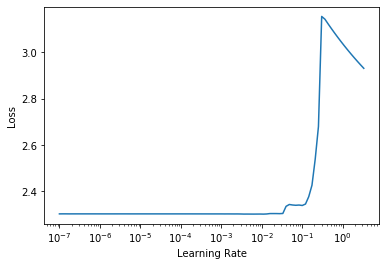

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy1,time
0,2.052737,1.953522,0.336667,07:07
1,1.953305,1.810193,0.423583,06:41
2,1.916734,1.739011,0.461750,06:35


# Simple CNN with BN

Batch Normalization allows us to use higher learning rate. This controls the distribution at every layer and hence model becomes more robust to the changes.

In [ ]:
model = SimpleCNNWITHBN(); model

SimpleCNNWITHBN(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1), padding=(3, 3))
  (conv2): Sequential(
    (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(40, 60, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_out): Conv2d(60, 10, kerne

Simple CNN

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp], cbs=[ActivationStats(with_hist=True)] ).to_fp16()

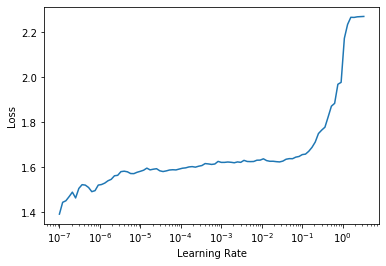

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy1,time
0,1.704890,1.495839,0.598833,05:01
1,1.640267,1.365731,0.663000,06:44
2,1.566960,1.294627,0.694000,06:36


# Fast.ai model

In [ ]:
model = Conv([64, 128, 64, 32],10)

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp] ).to_fp16()

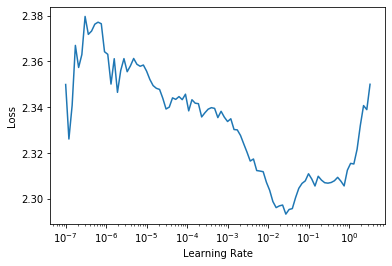

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-3 )

epoch,train_loss,valid_loss,accuracy1,time
0,1.847050,1.627134,0.485833,05:17
1,1.632174,1.377290,0.611833,05:01
2,1.579423,1.273897,0.673167,05:06


# ResNet

In [ ]:
model = ResNet2(BasicBlock, [2, 2, 2, 2])

In [ ]:
model

ResNet2(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp] ).to_fp16()

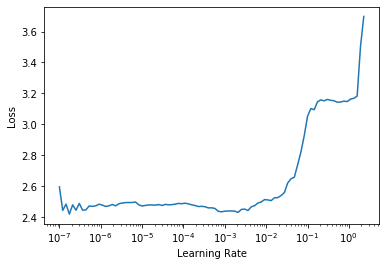

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy1,time
0,1.929051,1.731928,0.419333,07:08
1,1.702185,1.458189,0.580667,06:42
2,1.519251,1.283408,0.653250,07:14


In [ ]:
learn.summary()

ResNet2 (Input shape: ['16 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               16 x 64 x 16 x 16    9,408      True      
________________________________________________________________
BatchNorm2d          16 x 64 x 16 x 16    128        True      
________________________________________________________________
ReLU                 16 x 64 x 16 x 16    0          False     
________________________________________________________________
MaxPool2d            16 x 64 x 8 x 8      0          False     
________________________________________________________________
Conv2d               16 x 64 x 8 x 8      36,864     True      
________________________________________________________________
BatchNorm2d          16 x 64 x 8 x 8      128        True      
________________________________________________________________
ReLU                 16 x 64 x 8 x 8      0          False     
______________________________________________________

# Learner

In [ ]:
xb, yb = dbunch.one_batch()
xb.type()

'torch.cuda.FloatTensor'

In [ ]:
model = SimpleCNN().cuda()
score =model(xb)

C:\Users\t158185\Documents\GitHub\dl-notebooks\dlnotebooks\models\simplecnn.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
score.shape

torch.Size([16, 10])

In [ ]:
def accuracy1(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred.int() == targ).float().mean()

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp] ).to_fp16()

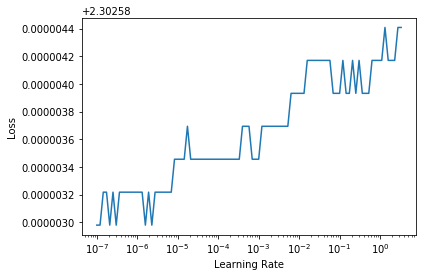

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-2 )

epoch,train_loss,valid_loss,accuracy1,time
0,2.302579,2.302577,0.100583,04:32
1,2.302579,2.302577,0.100583,04:32
2,2.302579,2.302577,0.100583,04:29


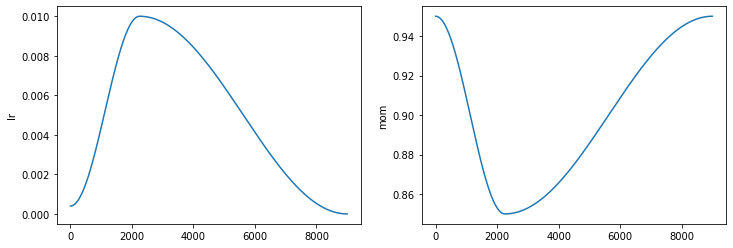

In [ ]:
learn.recorder.plot_sched()

# Looking inside the model

Lets see the impact of hooks

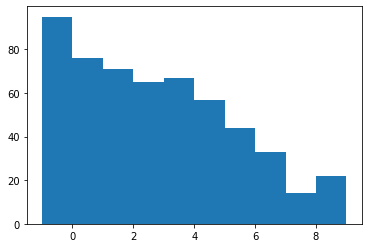

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
bins = np.array([i for i in range(-1,10)]).astype(float)
counts = hist.numpy().astype(float)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
plt.show()
assert np.allclose(bins_, bins)
assert np.allclose(counts_, counts)

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy1], cb_funcs =[MixUp], cbs=[ActivationStats(with_hist=True)] ).to_fp16()

In [ ]:
learn.fit_one_cycle(1,lr_max=10e-3)

epoch,train_loss,valid_loss,accuracy1,time
0,1.525807,1.151352,0.719917,10:17


In [ ]:
learn.activation_stats.stats

(#9000) [(#8) [{'mean': -2.106740713119507, 'std': 2.659578800201416, 'percent_null': 0.8172848183391004, 'hist': tensor([1.5900e+03, 2.5300e+03, 4.4400e+03, 6.4710e+03, 6.7350e+03, 4.4610e+03,
        2.8320e+03, 1.7450e+03, 1.1220e+03, 7.1500e+02, 4.5000e+02, 3.6400e+02,
        2.3800e+02, 1.2000e+02, 6.4000e+01, 9.4000e+01, 3.8000e+01, 4.0000e+01,
        2.3000e+01, 2.0000e+00, 7.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])},{'mean': -0.39247849583625793, 'std': 3.9204347133636475, 'percent_null': 0.6296226211072664, 'hist': tensor([19793., 13676.,  9880.,  6937.,  5262.,  4196.,  3432.,  2934.,  2633.,
         2670.,  2424.,  2556.,  2610.,  2826.,  2975.,  2992.,  3098.,  3261.,
         3439.,  3631.,  3623.,  3681.,  3828.,  3750.,  3589.,  3186.,  2599.,
      

In [ ]:
# debug layers 

tosave = defaultdict(list)
# for each batch, get $layer output
for i in range(len(learn.dbunch.train_dl)):
    for j in range(len(learn.activation_stats.modules)):
        tosave[j].append(learn.activation_stats.stats[i][j])

In [ ]:
len(learn.activation_stats.modules)

8

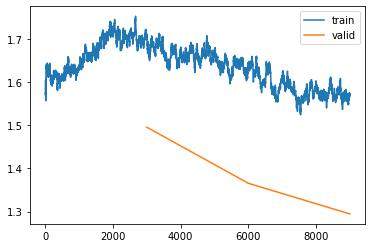

In [ ]:
learn.recorder.plot_loss()

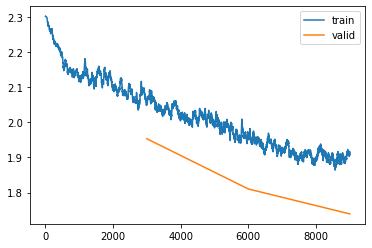

In [ ]:
learn.recorder.plot_loss()

Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')
Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')
Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')
Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')
Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')
Index(['mean', 'std', 'percent_null', 'hist'], dtype='object')


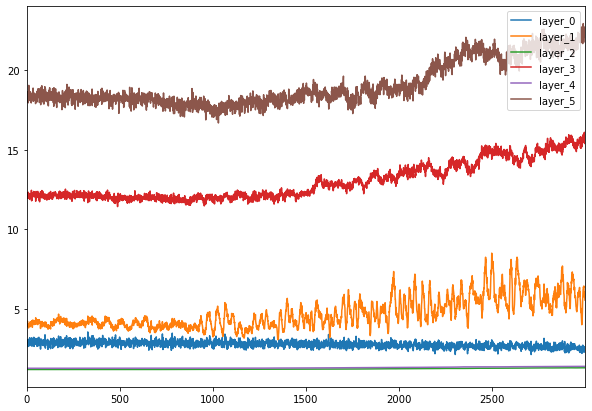

In [ ]:
layers = range(0,6)
ax = None
label = []
for l in layers:
    if len(tosave[l]) == 0:
        continue
    df = pd.DataFrame(tosave[l])
    print(df.columns)
    ax=df['std'].plot(ax=ax,figsize=(10,7))
    label.append("layer_"+str(l))

ax.legend(label, loc='upper right')